# DSC 550 Project Milestone2
# Aditya Sumbaraju
# 07/22/2021

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

<Figure size 640x480 with 0 Axes>

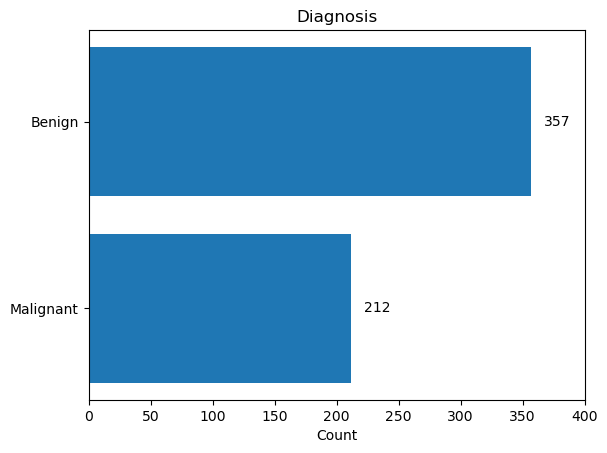

NameError: name 'df' is not defined

In [1]:
#Recap of Milestone1. Import the Charts from Milestone1
from ipynb.fs.full.ASumbaraju_Project_Milestone1 import *

# Project Milestone 2

# In Milestone 2, you should drop any features that are not useful for your model building. You should explain and justify why the feature dropped is not useful. You should address any missing data issues. Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary. Explain your process at each step. You can use any methods/tools you think are most appropriate

In [176]:

#Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import cross_val_score
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
warnings.filterwarnings(action="ignore")

In [146]:
#Step 1: Load data into a dataframe
bc_df = "C:\BU\DSC550\project\data/data.csv"
data = pd.read_csv(bc_df)

In [147]:
print('******************************************************************************** ')
print('Numerical variable summary: \n')
print(data.describe())
print('******************************************************************************** ')
print('Categorical variable summary: \n')
print(data.describe(include = ['O']))
print('******************************************************************************** ')

******************************************************************************** 
Numerical variable summary: 

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          

In [148]:
# removing id and unnamed: 32 column which is not necessary for our model
bc_df = "C:\BU\DSC550\project\data/data.csv"
data = pd.read_csv(bc_df)
data = data.drop(['id'],axis = 1)

In [169]:
# Mapping our target variable to 1 and 0
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['diagnosis'] = le.fit_transform(data['diagnosis'])
data.diagnosis.value_counts(normalize = True)
# dataset seem to be pretty balanced - Categorical variable Benign'B' stands 63% and Malignant 'M' stands 37%

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

<AxesSubplot:>

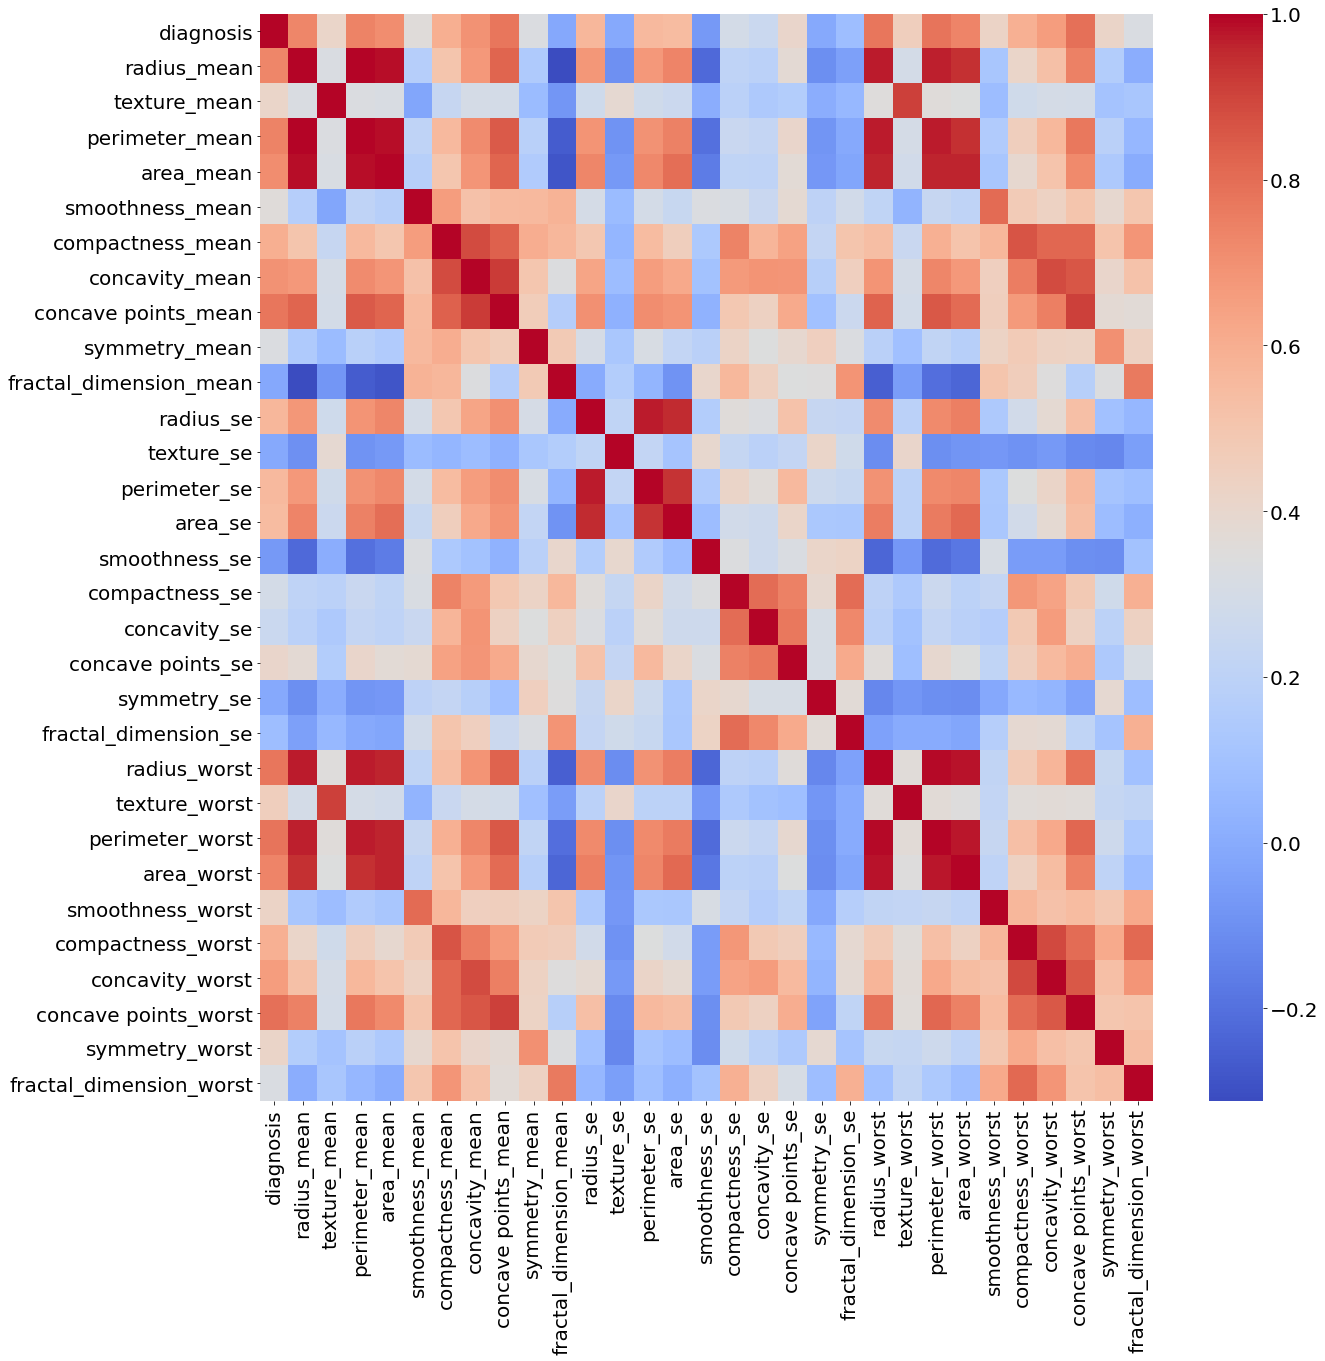

In [175]:
# Finding correlation for all features using sns' heatmap
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=False,cmap='coolwarm')

In [152]:
def fig_box_plot(data_frame, data_set_name, xlim=None):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
    #ax.set_axis_bgcolor('#fafafa')
    if xlim is not None:
        plt.xlim(*xlim)
    plt.ylabel('Dependent Variables')
    plt.title("Box Plot of {0}"\
        .format(data_set_name))
    #including all dependent variables
    ax = sns.boxplot(data = data_frame,
                     orient = 'h', 
                     palette = colors)

    plt.show()
    plt.close()

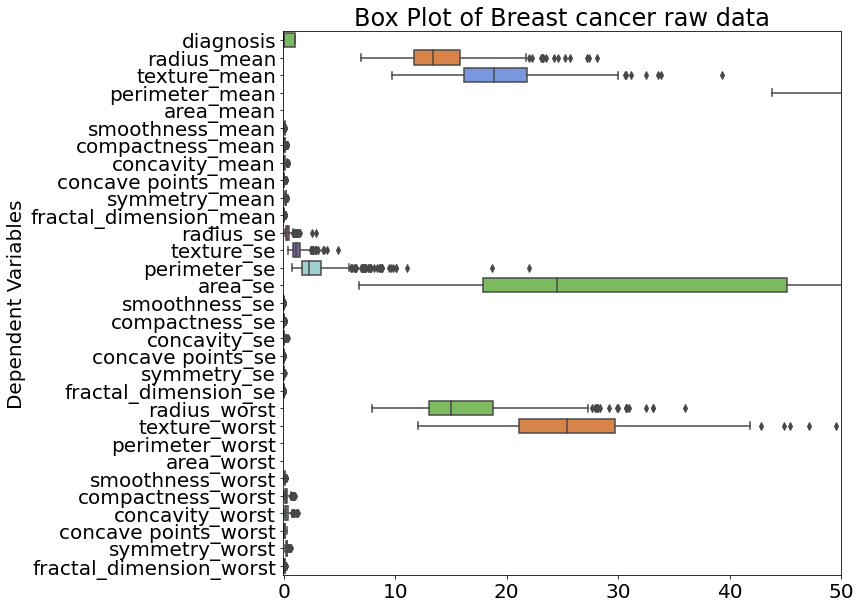

In [154]:
fig_box_plot(data, 
              'Breast cancer raw data', 
              (-.05, 50))

In [155]:
# fix the box plot by normalizing the data
 
def norm_data_frame(data_frame):
    #Intializing an empty data frame
    df_norm = pd.DataFrame()
    for col in data_frame:
        #normalize all columns that  have at > 20 unique values
        if ((len(np.unique(data_frame[col])) > 20) & (data_frame[col].dtype != 'object')):
            df_norm[col]=((data_frame[col] - data_frame[col].min()) /
                                  (data_frame[col].max() - data_frame[col].min()))
        else:
            df_norm[col] = data_frame[col]
    return df_norm
#Normalized dataframe values ranging (0, 1) 

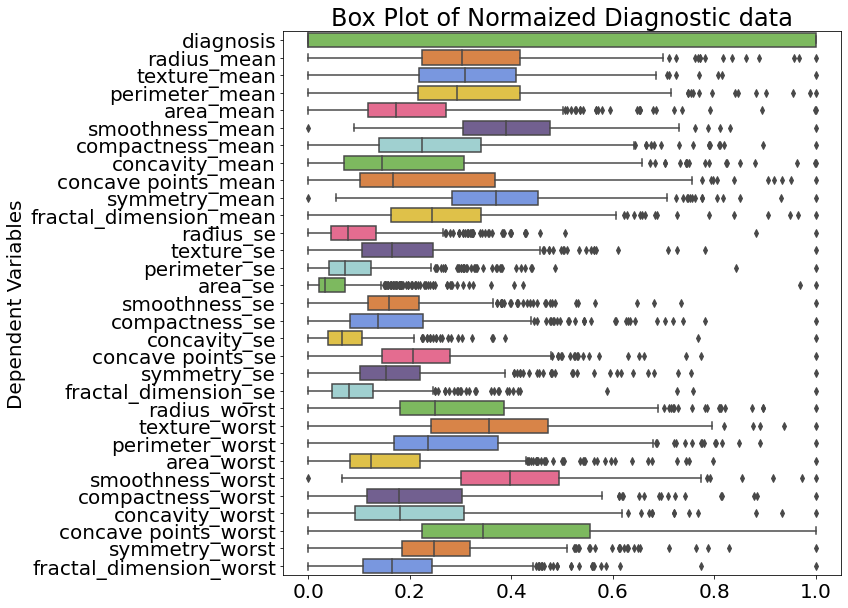

In [157]:
fig_box_plot(norm_data_frame(data), 
              'Normaized Diagnostic data', 
              (-.05, 1.05))
# If we observe the median of area_mean,concave points_se,area_worst, concave points_worst they are slightly towards first quartile q1
# We can consider these features for dropping

In [158]:
#Converting all categorical features to numerical features using Pandas get_dummies().
#This will allow RFECV to be used for feature selection.
df_dummies = pd.get_dummies(data)

In [159]:
feature_space = data.iloc[:, data.columns != 'diagnosis']
feature_class = data.iloc[:, data.columns == 'diagnosis']

In [160]:
#Shape of the dummy data frame
print('Shape of the dummy variable data frame: {}'.format(df_dummies.shape))

print('Features:', feature_space)
print('Target:', feature_class)

Shape of the dummy variable data frame: (569, 31)
Features:      radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

   

In [161]:
# fetch the required features using RFECV - Recursive Feature Elimination and Cross-Validation Selection 
# witht he help of RFECV we can eliminate the irrelevent features based on scoring. 
# I am using f1_weighted - It results in an F-score that is not between precision and recall

logreg = LogisticRegression()
rfecv = RFECV(estimator = logreg, step = 1, scoring = "f1_weighted")
rfecv.fit(feature_space, np.ravel(feature_class))
required_features = pd.DataFrame(rfecv.transform(feature_space))


In [177]:
# fetch the results of required_features
print('Count of required features: {} out of {}'.format(rfecv.n_features_, len(df_dummies.columns)))
print(rfecv.support_)
print (df_dummies.columns)

#We can keep 22 of the 26 features of the dummy data frame. 
# Map "False" with df_dummies.columns to identify the columns that is not required for modeling.
# eliminated Columns are area_mean,concave points_se,area_worst


Count of required features: 24 out of 31
[ True  True  True False  True  True  True  True  True False  True  True
  True  True False  True  True False False False  True  True  True  True
  True  True  True  True  True  True]
Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [163]:
#Let try to select top 5 features based on F_scores
selector = SelectKBest(f_classif, k = 5)
X = data.drop(['diagnosis'], axis = 1)
y = data['diagnosis']
X_new = selector.fit_transform(X, y)
col_names = X.columns.values[selector.get_support()]
F_scores = selector.scores_[selector.get_support()]
names_scores = list(zip(col_names, F_scores))
scores_df = pd.DataFrame(data = names_scores, columns=['Feature_names', 'F_Scores'])
#Sort the dataframe for better visualization
scores_df_sorted = scores_df.sort_values(['F_Scores', 'Feature_names'], ascending = [False, True])
print(scores_df_sorted)

          Feature_names    F_Scores
4  concave points_worst  964.385393
3       perimeter_worst  897.944219
1   concave points_mean  861.676020
2          radius_worst  860.781707
0        perimeter_mean  697.235272


In [164]:
# SelectKBest proves that the top 5 features are not contributing to eliminiated features using RFECV and box plots
# hence it is safe to eliminate the features area_mean,concave points_se,area_worst

# Logistic Regression

In [165]:
# Train Test Split 
# remove the features area_mean,concave points_se,area_worst from training and test subsets
from sklearn.model_selection import train_test_split

X = data.drop(['diagnosis','area_mean','concave points_se','area_worst'], axis = 1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
# number of samples in each set
print("No. of samples in training set: ", X_train.shape[0])
print("No. of samples in validation set:", X_test.shape[0])

# Benign and Malignant
print('\n')
print('No. of Benign and Malignant diagnosis in the training set:')
print(y_train.value_counts())

print('\n')
print('No. of Benign and Malignant diagnosis in the validation set:')
print(y_test.value_counts())

No. of samples in training set:  455
No. of samples in validation set: 114


No. of Benign and Malignant diagnosis in the training set:
0    290
1    165
Name: diagnosis, dtype: int64


No. of Benign and Malignant diagnosis in the validation set:
0    67
1    47
Name: diagnosis, dtype: int64


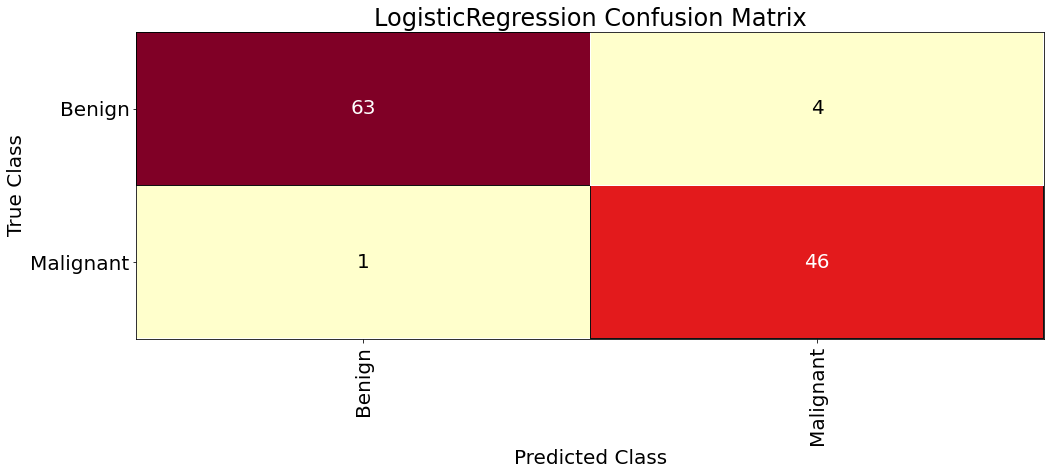

In [166]:
# Instantiate the classification model 
model = LogisticRegression()

#The ConfusionMatrix visualizer taxes a model
classes = ['Benign','Malignant']
cm = ConfusionMatrix(model, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test, y_test)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

#How did we do? 
# the true positive value for Benign is 63, it means 63 positive class data points were correctly classified by the model 
# true negitive value for malignant is 46, it means 46 negative class data points were correctly classified by the model 
# this proves the predicted values match the actual values
# the false positive is 1 and false negitive is 4 - these values are significantly low in number; hence we can say we are good with this model
# if calculate the accuracy based on confusion matrix 
# formulae (TP+TN)/(TP+TN+FP+FN)= (63+46)/(63+46+1+4)= 109/114= 0.95 i.e 95 % of accuracy.
cm.poof()
plt.show()

# reference: https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/

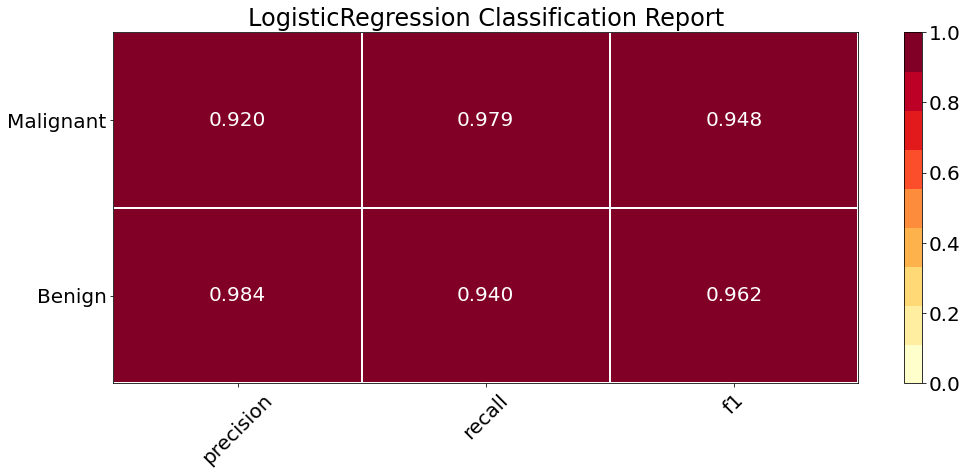

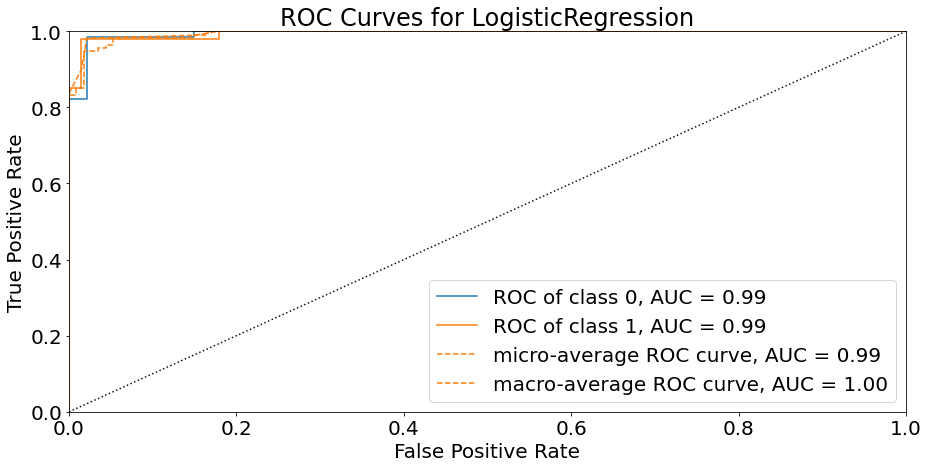

In [167]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

In [168]:
#Area under the ROC Curve 
#AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
# AUC is an effective way to summarize the overall diagnostic accuracy of the test. It takes values from 0 to 1, where a value of 0 indicates a perfectly inaccurate test and a value of 1 reflects a perfectly accurate test.
# in our case study:
# ROC- Receiver Operating Characteristic Class 0 - Benign AUC=0.99 and 
# ROC- Receiver Operating Characteristic Class 1 - Malignant AUC=0.99 
# this indicates that test considered as excellent 
# ROC curves above the diagonal line are considered to have reasonable discriminating ability to diagnose patients with and without the breast cancer. 

# reference: https://www.sciencedirect.com/science/article/pii/S1556086415306043

# End Of Project Milestone2